In [1]:
import os
os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 

In [2]:
from pl_temp_fit import PLPYMCModel
import importlib
import arviz as az
importlib.reload(PLPYMCModel)

<module 'pl_temp_fit.PLPYMCModel' from '/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/PLPYMCModel.py'>

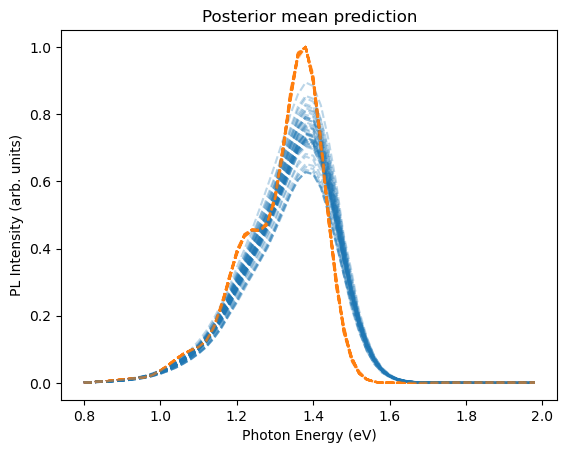

In [3]:
import numpy as np
import matplotlib.pyplot as plt

model_config = {
            "number_free_parameters": 2,
            "sigma": 0.01,
            "Temp_std_err": 0.1,
            "hws_std_err": 0.001,
            "relative_intensity_std_error": 0.05,
        }
def generate_data(temperature_list, hws,sigma,Temp_std_err,hws_std_err,relative_intensity_std_error,number_free_parameters):
    E_true = 1.5
    sigma_true = 0.02
    LI_true = 0.09
    L0_true = 0.1
    H0_true = 0.15
    # error in the temperature of the sample
    temperature_list = temperature_list+np.random.normal(0, Temp_std_err, len(temperature_list))
    # error in the detection wavelength
    hws = hws+np.random.normal(0, hws_std_err, len(hws))
    truemodel_pl = PLPYMCModel.pl_trial(
        [E_true, sigma_true, LI_true, L0_true, H0_true], temperature_list, hws
    ) 
    # relative intensity error
    relative_intensity_model = np.max(truemodel_pl, axis=0)/max(truemodel_pl.reshape(-1, 1))
    relative_intensity_model_error = relative_intensity_model + np.random.normal(0, relative_intensity_std_error, len(relative_intensity_model))
    relative_intensity_model_error= relative_intensity_model_error/np.max(relative_intensity_model_error)
    truemodel_pl=truemodel_pl * relative_intensity_model_error / relative_intensity_model
    relative_intensity_model = np.max(truemodel_pl, axis=0)/max(truemodel_pl.reshape(-1, 1))
    # uniform error accross the spectrum
    truemodel_pl = truemodel_pl+np.random.normal(0, sigma, size=(len(hws), len(temperature_list)))

    true_parameters = [E_true, sigma_true, LI_true, L0_true, H0_true]
    return truemodel_pl, true_parameters
sigma=0.01
temperature_list=np.array([300.0, 150.0])
hws=np.arange(0.8, 2, 0.02)
X = {'temperature_list':temperature_list,'hws':hws}
fig, ax = plt.subplots()
for x in range(50):
    truemodel_pl, true_parameters = generate_data(temperature_list, hws,**model_config)
    data_true_plot = truemodel_pl.reshape(len(hws), -1)
    
    for i in range(len(temperature_list)):
        ax.plot(
            hws,
            data_true_plot[:, i]/max(data_true_plot.reshape(-1, 1)),
            label="true" + str(temperature_list[i]) + " K",
            linestyle="--",
            color="C" + str(i),
            alpha=0.3,
        )
    ax.set_xlabel("Photon Energy (eV)")
    ax.set_ylabel("PL Intensity (arb. units)")
    ax.set_title("Posterior mean prediction")
    #ax.legend()


In [12]:
#   Copyright 2023 The PyMC Developers
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
from typing import Callable, Dict, List, Optional, Tuple

import numpy as np
import numpy.random as nr
import pytensor
import scipy.linalg
import scipy.special

from pytensor import tensor as pt

import pymc as pm

from pymc.blocking import RaveledVars,DictToArrayBijection
from pymc.pytensorf import (
    CallableTensor,
    compile_pymc,
    floatX,
    join_nonshared_inputs,
    replace_rng_nodes,
)
from pymc.step_methods.arraystep import (

    StatsType,
    metrop_select,
)

__all__ = [
    "Metropolis",
    "DEMetropolis",
    "DEMetropolisZ",
    "BinaryMetropolis",
    "BinaryGibbsMetropolis",
    "CategoricalGibbsMetropolis",
    "NormalProposal",
    "CauchyProposal",
    "LaplaceProposal",
    "PoissonProposal",
    "MultivariateNormalProposal",
]

from pymc.util import get_value_vars_from_user_vars

# Available proposal distributions for Metropolis


class Proposal:
    def __init__(self, s):
        self.s = s




class NormalProposal(Proposal):
    def __call__(self, rng: Optional[np.random.Generator] = None):
        return (rng or nr).normal(scale=self.s)





class UniformProposal(Proposal):
    def __call__(self, rng: Optional[np.random.Generator] = None):
        return (rng or nr).uniform(low=-self.s, high=self.s, size=len(self.s))





class CauchyProposal(Proposal):
    def __call__(self, rng: Optional[np.random.Generator] = None):
        return (rng or nr).standard_cauchy(size=np.size(self.s)) * self.s





class LaplaceProposal(Proposal):
    def __call__(self, rng: Optional[np.random.Generator] = None):
        size = np.size(self.s)
        r = rng or nr
        return (r.standard_exponential(size=size) - r.standard_exponential(size=size)) * self.s





class PoissonProposal(Proposal):
    def __call__(self, rng: Optional[np.random.Generator] = None):
        return (rng or nr).poisson(lam=self.s, size=np.size(self.s)) - self.s





class MultivariateNormalProposal(Proposal):


    def __init__(self, s):
        n, m = s.shape
        if n != m:
            raise ValueError("Covariance matrix is not symmetric.")
        self.n = n
        self.chol = scipy.linalg.cholesky(s, lower=True)


    def __call__(self, num_draws=None, rng: Optional[np.random.Generator] = None):
        rng_ = rng or nr
        if num_draws is not None:
            b = rng_.normal(size=(self.n, num_draws))
            return np.dot(self.chol, b).T
        else:
            b = rng_.normal(size=self.n)
            return np.dot(self.chol, b)




class DEMetropolis(pm.DEMetropolis):

    def astep(self, q0: RaveledVars) -> Tuple[RaveledVars, StatsType]:
        point_map_info = q0.point_map_info
        q0d = q0.data

        if not self.steps_until_tune and self.tune:
            if self.tune == "scaling":
                self.scaling = tune(self.scaling, self.accepted / float(self.tune_interval))
            elif self.tune == "lambda":
                self.lamb = tune(self.lamb, self.accepted / float(self.tune_interval))
            # Reset counter
            self.steps_until_tune = self.tune_interval
            self.accepted = 0

        epsilon = self.proposal_dist() * self.scaling

        # differential evolution proposal
        # select two other chains
        ir1, ir2 = np.random.choice(self.other_chains, 2, replace=False)
        r1 = DictToArrayBijection.map(self.population[ir1])
        r2 = DictToArrayBijection.map(self.population[ir2])
        # propose a jump
        q = floatX(q0d + self.lamb * (r1.data - r2.data) + epsilon)

        accept = self.delta_logp(q, q0d)
        q_new, accepted = metrop_select(accept, q, q0d)
        self.accepted += accepted

        self.steps_until_tune -= 1

        stats = {
            "tune": self.tune,
            "scaling": np.mean(self.scaling),
            "lambda": self.lamb,
            "accept": np.exp(accept),
            "accepted": accepted,
        }

        return RaveledVars(q_new, point_map_info), [stats]


def sample_except(limit, excluded):
    candidate = nr.choice(limit - 1)
    if candidate >= excluded:
        candidate += 1
    return candidate


def delta_logp(
    point: Dict[str, np.ndarray],
    logp: pt.TensorVariable,
    vars: List[pt.TensorVariable],
    shared: Dict[pt.TensorVariable, pt.sharedvar.TensorSharedVariable],
) -> pytensor.compile.Function:
    [logp0], inarray0 = join_nonshared_inputs(
        point=point, outputs=[logp], inputs=vars, shared_inputs=shared
    )

    tensor_type = inarray0.type
    inarray1 = tensor_type("inarray1")

    logp1 = CallableTensor(logp0)(inarray1)
    # Replace any potential duplicated RNG nodes
    (logp1,) = replace_rng_nodes((logp1,))

    f = compile_pymc([inarray1, inarray0], logp1 - logp0)
    f.trust_input = True
    return f

{'number_free_parameters': 2, 'E': {'min': 1.0, 'max': 2.0}, 'sigma_E': {'min': 0.001, 'max': 0.03}, 'LI': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'L0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'H0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.12, 'upper': 0.18}, 'Temp_std_err': 0.1, 'hws_std_err': 0.001, 'relative_intensity_std_error': 0.05, 'sigma': 0.01}


Only 10 samples in chain.


{'draws': 10, 'tune': 5, 'chains': 3, 'return_inferencedata': True}


Population sampling (3 chains)
DEMetropolis: [E, LI]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 3 chains for 5 tune and 10 draw iterations (15 + 30 draws total) took 2 seconds.
The number of samples is too small to check convergence reliably.
/var/tmp/pbs.8702828.pbs/ipykernel_279454/3545840855.py:17: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_prior_predictive(), join="right")
Sampling: [E, LI]
/var/tmp/pbs.8702828.pbs/ipykernel_279454/3545840855.py:18: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata), join="right")
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'H0', 'L0', 'sigma_E'} expected from {'LI', 'E'}
 

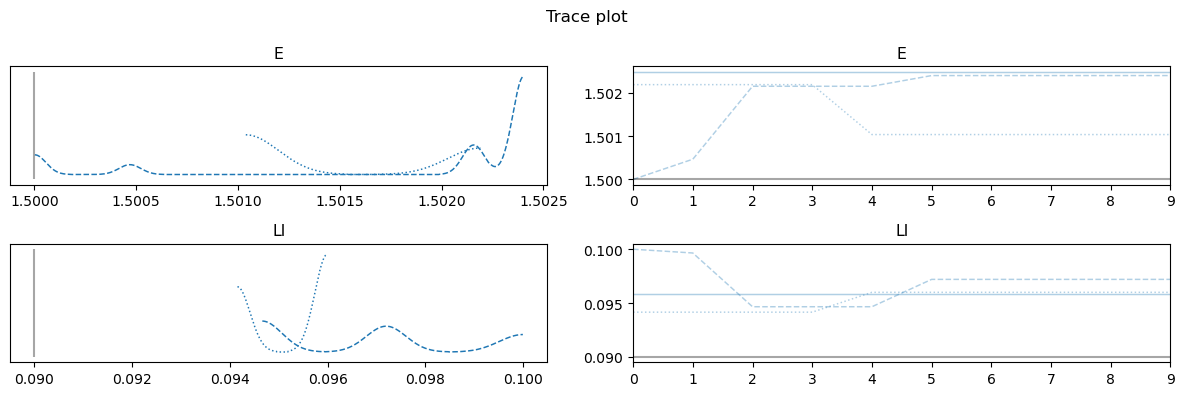

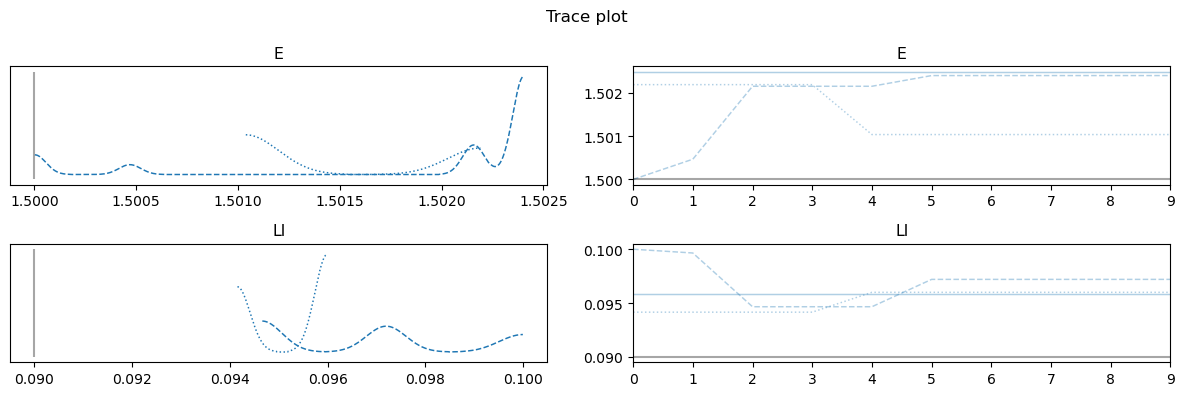

In [14]:
import pymc as pm
model = PLPYMCModel.PLPYMCModel()
for key, value in model_config.items():
    model.model_config[key] =  value
model._generate_and_preprocess_model_data(X, truemodel_pl)
model.build_model(model.X, model.y, 0.01)

print(model.model_config)
with model.model:
    sampler_args = {**model.sampler_config}
    
    step = DEMetropolis(scaling=[0.01,0.1])
    sampler_args.pop('step')
    print(sampler_args)

    idata = pm.sample(step=step,**sampler_args)
    idata.extend(pm.sample_prior_predictive(), join="right")
    idata.extend(pm.sample_posterior_predictive(idata), join="right")
model.idata = idata
model.plot_trace(true_parameters, save_folder="", savefig=False)



{'number_free_parameters': 2, 'E': {'min': 1.0, 'max': 2.0}, 'sigma_E': {'min': 0.001, 'max': 0.03}, 'LI': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'L0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.05, 'upper': 0.15}, 'H0': {'mu': 0.12, 'sigma': 0.01, 'lower': 0.12, 'upper': 0.18}, 'Temp_std_err': 0.1, 'hws_std_err': 0.001, 'relative_intensity_std_error': 0.05, 'sigma': 0.01}
{'draws': 50, 'tune': 5, 'chains': 4, 'return_inferencedata': True, 'progressbar': True, 'random_seed': None}


Only 50 samples in chain.
Population sampling (4 chains)
DEMetropolis: [E, LI]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 5 tune and 50 draw iterations (20 + 200 draws total) took 7 seconds.
The number of samples is too small to check convergence reliably.
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/PLPYMCModel.py:186: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_prior_predictive(), join="right")
Sampling: [E, LI]
/rds/general/user/ma11115/home/pl_temp_fit/src/pl_temp_fit/PLPYMCModel.py:187: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata), join="right")
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'H0', 'L0',

max_ rhat 1.19


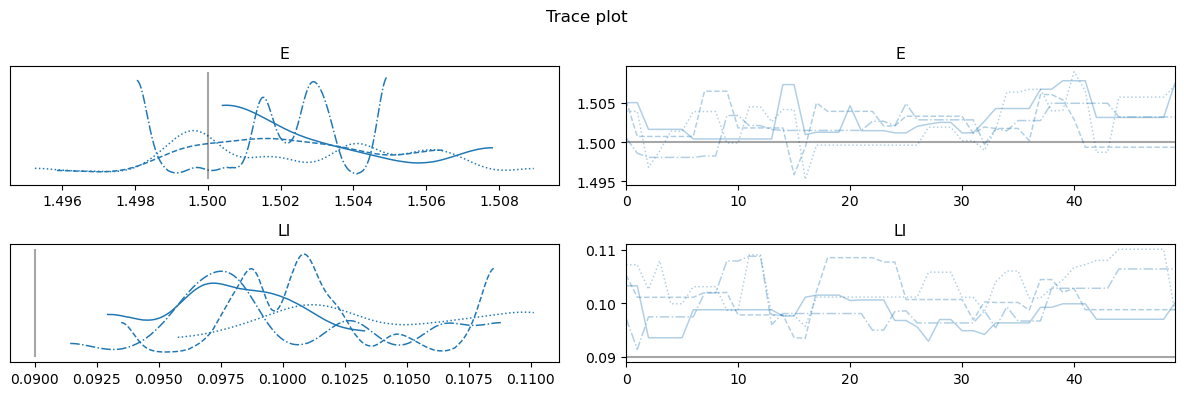

In [16]:
from pl_temp_fit.Sampler import DEMetropolis
import importlib 
importlib.reload(PLPYMCModel)
model = PLPYMCModel.PLPYMCModel()
for key, value in model_config.items():
    model.model_config[key] =  value
print(model.model_config)
max_rhat=3
model.fit(X, truemodel_pl, draws=50, tune=5, chains=4, step="DEMetropolis(scaling=[0.01,0.1])",return_inferencedata=True)
max_rhat = max(az.summary(model.idata)['r_hat'].values)
model.plot_trace(true_parameters, save_folder="", savefig=False)
print('max_ rhat', max_rhat)
#while (max_rhat>1.1):
#model.idata = model.sample_model(draws=1000, tune=500, chains=4, step="pm.Metropolis()",return_inferencedata=True)
#max_rhat = max(az.summary(model.idata)['r_hat'].values)
#print('max_ rhat', max_rhat)
#model.plot_trace(true_parameters, save_folder="", savefig=False)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
E,1.494,0.028,1.438,1.513,0.005,0.004,10.0,8.0,3.43
LI,0.090,0.006,0.082,0.094,0.001,0.001,9.0,13.0,1.43


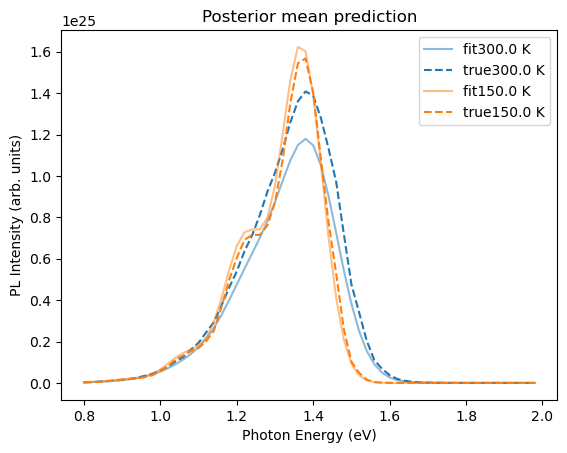

In [191]:
model.plot_posterior_prediction(truemodel_pl,  temperature_list, hws, save_folder="", savefig=False)
az.summary(model.idata)

In [19]:
import arviz as az
model.idata.sample_stats["accepted"].values.shape
list(model.idata.sample_stats.data_vars)
az.summary(model.idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
E,1.518,0.014,1.491,1.544,0.001,0.001,90.0,190.0,1.05
sigma_E,0.013,0.008,0.001,0.026,0.001,0.000,192.0,513.0,1.01
LI,0.112,0.008,0.098,0.127,0.000,0.000,669.0,886.0,1.01
L0,0.114,0.010,0.096,0.132,0.001,0.001,155.0,310.0,1.03
H0,0.123,0.010,0.104,0.141,0.000,0.000,560.0,850.0,1.01


<xarray.DataArray 'accept' (chain: 4, accept_dim_0: 5)>
array([[1.20038607e-01, 4.33129095e+07, 4.21654195e+00, 2.23375930e+03,
        1.59868332e+00],
       [1.39808729e-04, 1.28466050e+00, 2.05672050e+00, 3.32498139e+00,
        1.37351198e+04],
       [1.74736209e-14, 1.05873975e+00, 4.19747578e+00, 6.97171950e+03,
        1.95931221e+01],
       [1.82771671e+00, 1.47560570e+00, 8.40187154e+00, 2.01109269e+01,
        1.64129638e+08]])
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * accept_dim_0  (accept_dim_0) int64 0 1 2 3 4

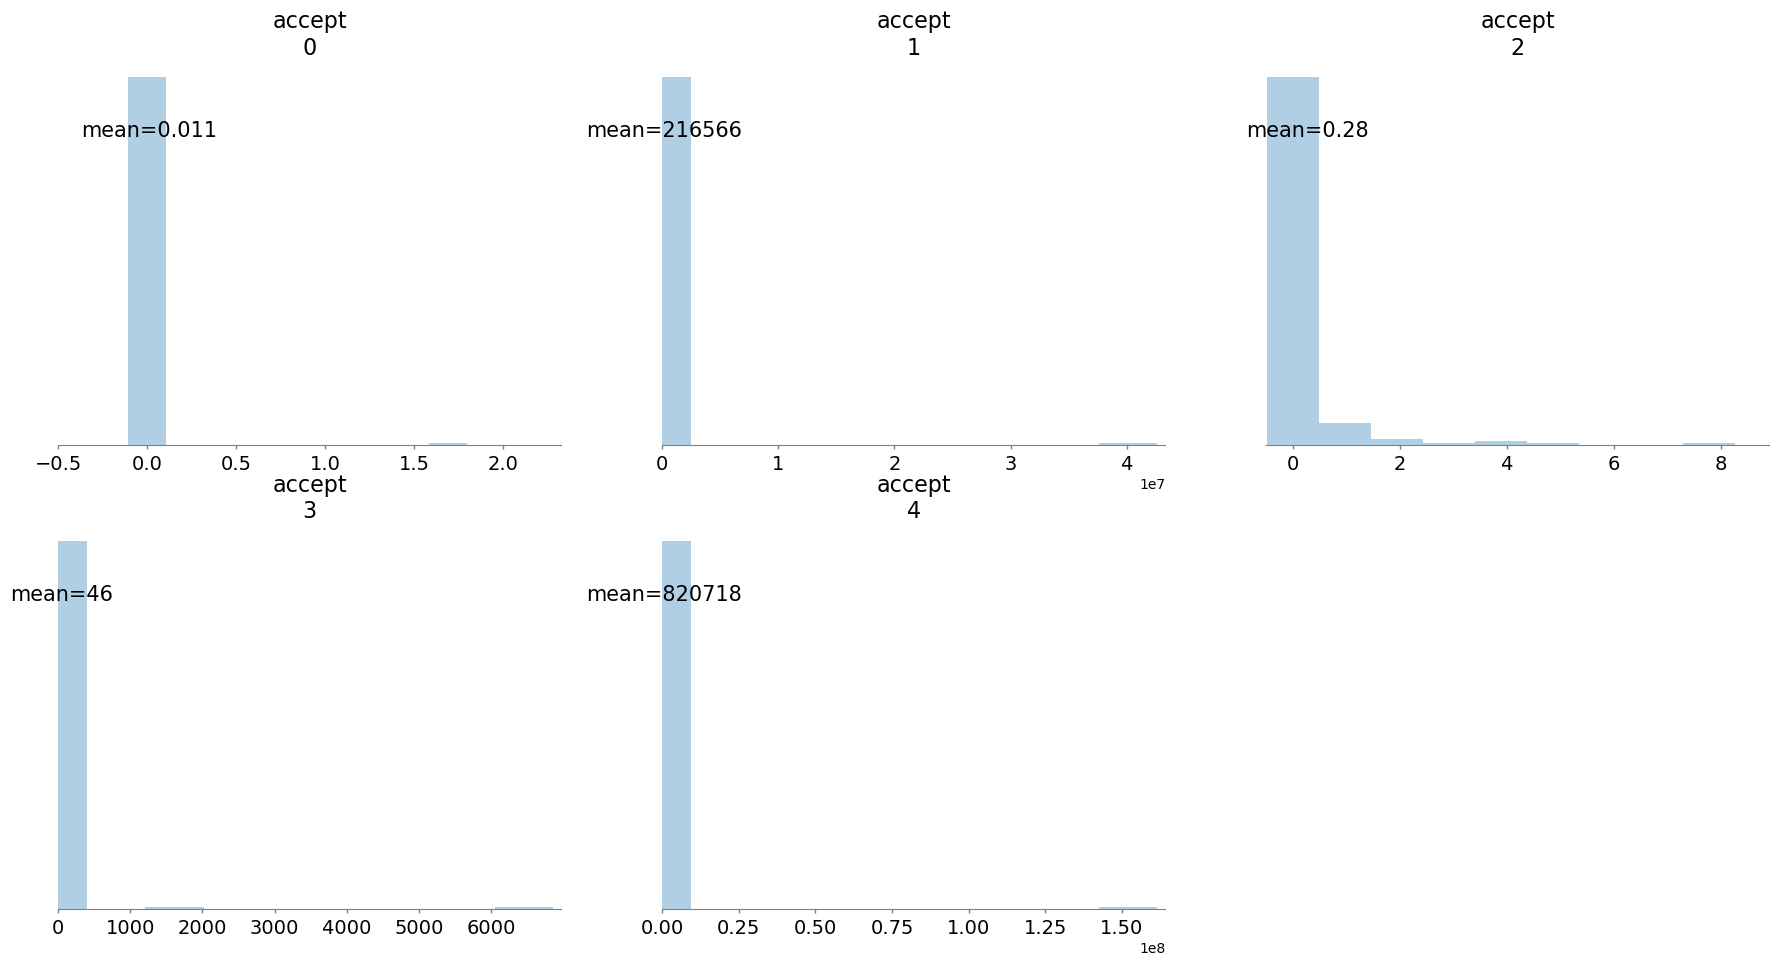

In [135]:
idata= model.idata
list(model.idata.sample_stats.data_vars)
az.plot_posterior(
    idata,
    group="sample_stats",
    var_names="accept",
    hdi_prob="hide",
    kind="hist",
);
# Range of accept values
idata.sample_stats["accept"].max("draw") - idata.sample_stats["accept"].min("draw")

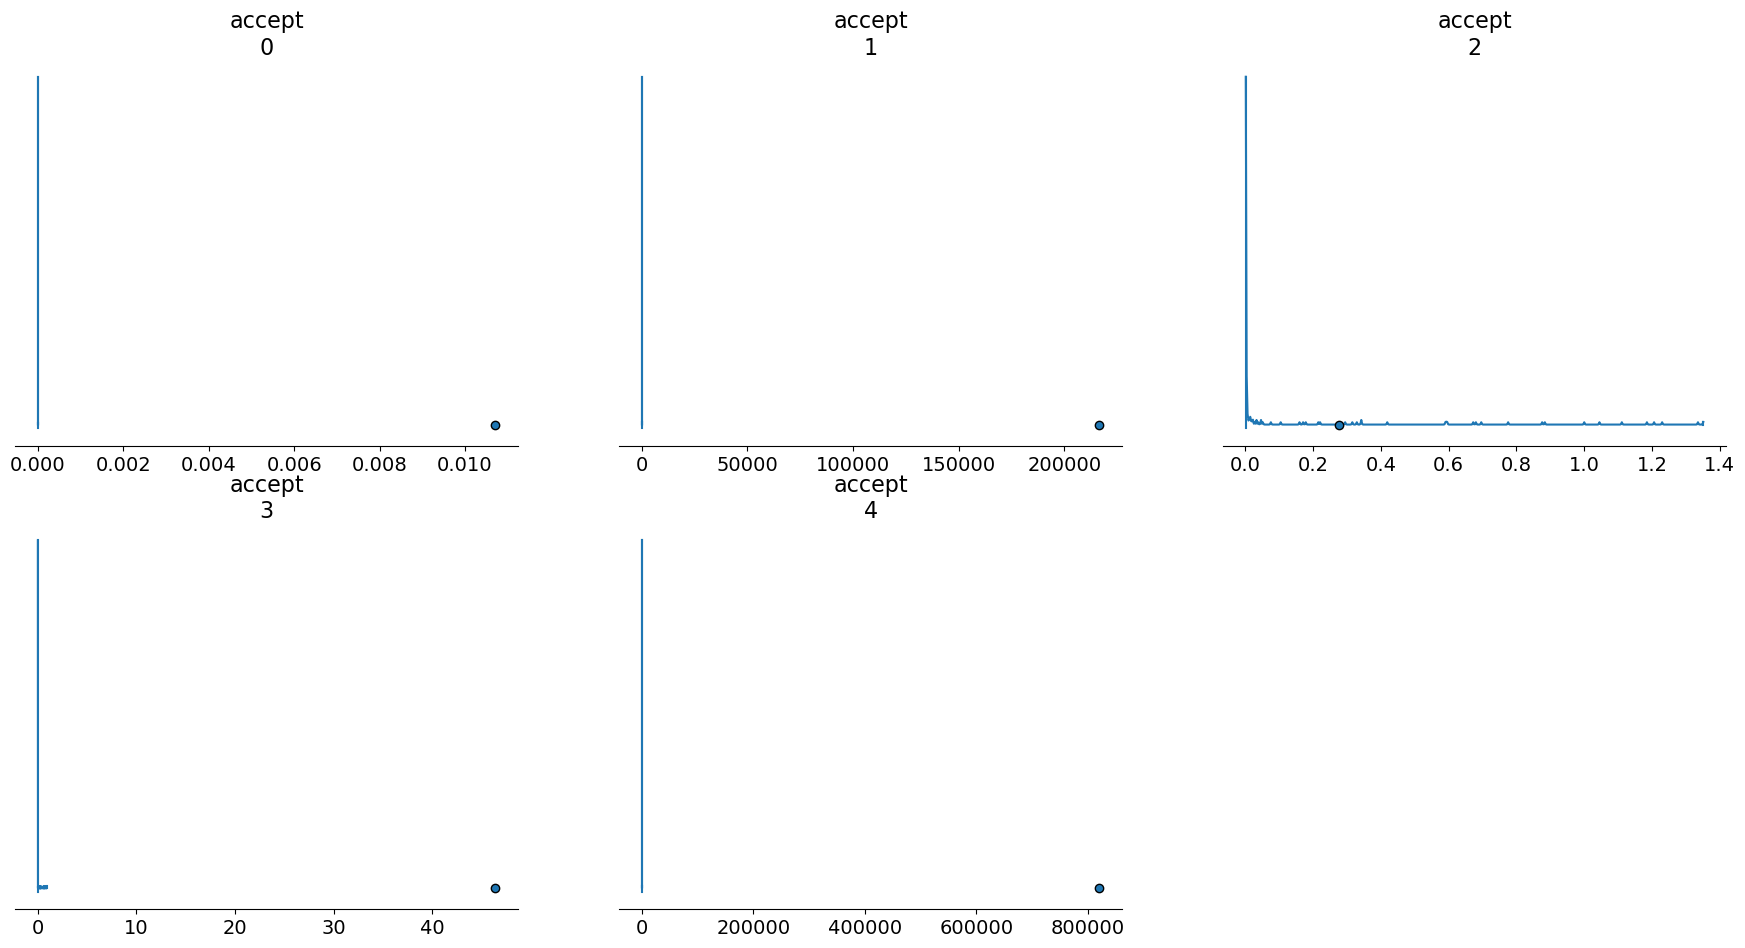

In [136]:
# We can try plotting the density and view the high density intervals to understand the variable better
az.plot_density(
    idata,
    group="sample_stats",
    var_names="accept",
    point_estimate="mean",
);

In [86]:
fname = "test.nc"
model.save(fname)

/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'sigma', 'H0', 'L0'} expected from {'LI', 'E'}
  warnings.warn(


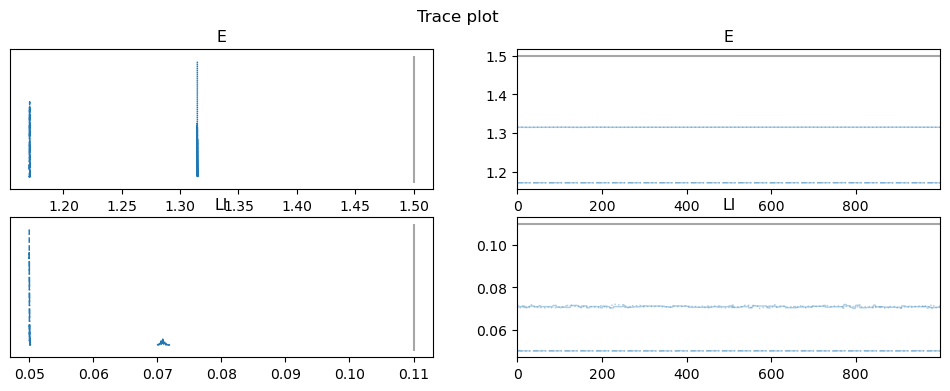

In [87]:
plot_trace(model.idata, true_parameters, "", savefig=False)

In [1]:
model.model_config

NameError: name 'model' is not defined

{'draws': 10, 'tune': 5, 'chains': 4, 'return_inferencedata': True, 'progressbar': True, 'random_seed': None}


Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [E]
>Metropolis: [LI]


/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 5 tune and 10 draw iterations (20 + 40 draws total) took 6 seconds.
The number of samples is too small to chec

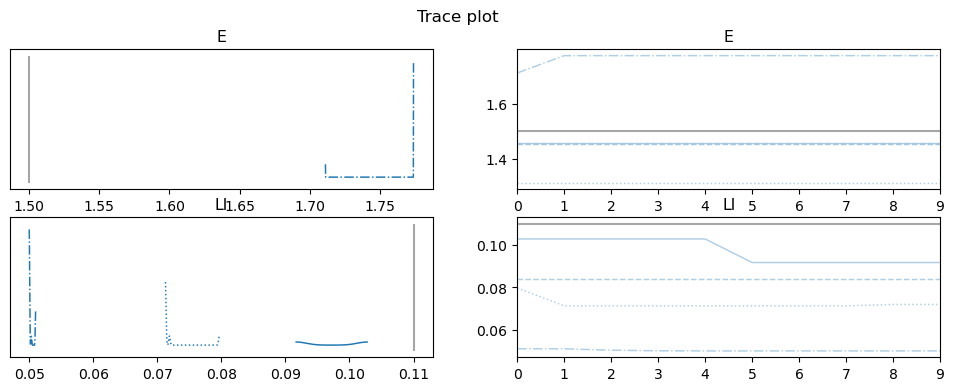

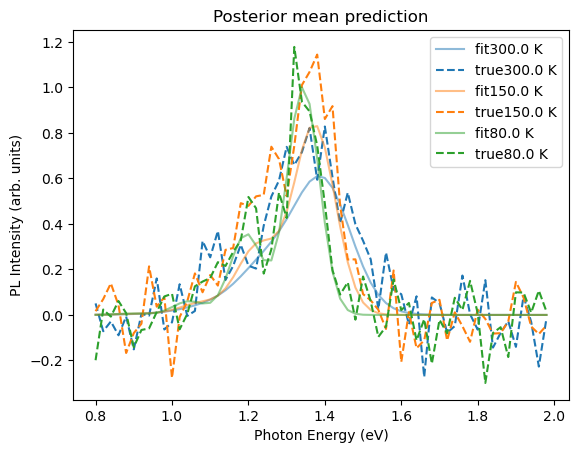

In [93]:
model_2.fit(X, np.concatenate(truemodel_pl), draws=10, tune=5, chains=4, step="pm.Metropolis()",return_inferencedata=True)

plot_posterior_prediction(model_2.idata, truemodel_pl, temperature_list, hws, "", savefig=False)


Running on PyMC v5.9.2
Running test number 0
{'num_samples': 100, 'num_tune': 50, 'sigma': 0.02, 'temperature_list': array([300., 250., 200., 150.,  80.]), 'number_free_parameters': 2}
calling the sampler


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [E]
>Metropolis: [LI]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 77 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'sigma', 'L0', 'H0'} expected from {'LI', 'E'}
  warnings.warn(
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


KeyError: 'values'

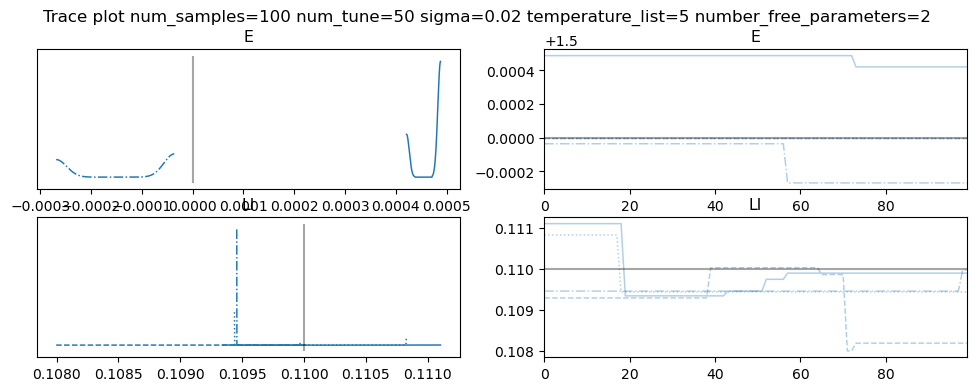

In [48]:
%run src/pl_temp_fit/test_PYMC_pl.py --test_number 0

In [45]:
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=32:mem=4gb:avx=true \n"+\
    f"#PBS -J 1-{162} \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pymc_env     \n"+\
    f"python src/pl_temp_fit/test_PYMC_pl.py --test_number ${'PBS_ARRAY_INDEX'} \n"
#print(script) 
with open(f'HPC_bash_script/Runtest.sh', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  

!qsub  -e ./cache -o ./cache HPC_bash_script/Runtest.sh

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
sh: which: line 1: syntax error: unexpected end of file


Running on PyMC v5.10.3
calling the sampler


Only 10 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [E]
>Metropolis: [LI]


Sampling 4 chains for 5 tune and 10 draw iterations (20 + 40 draws total) took 5 seconds.
The number of samples is too small to check convergence reliably.
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'sigma', 'H0', 'L0'} expected from {'LI', 'E'}
  warnings.warn(
/rds/general/user/ma11115/home/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


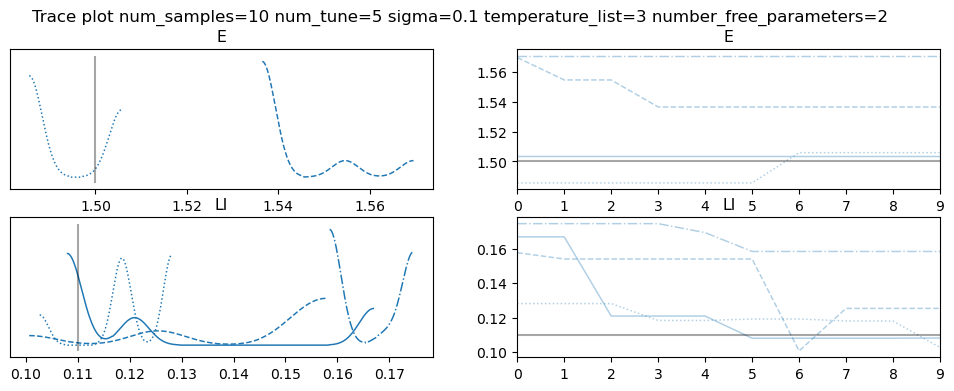

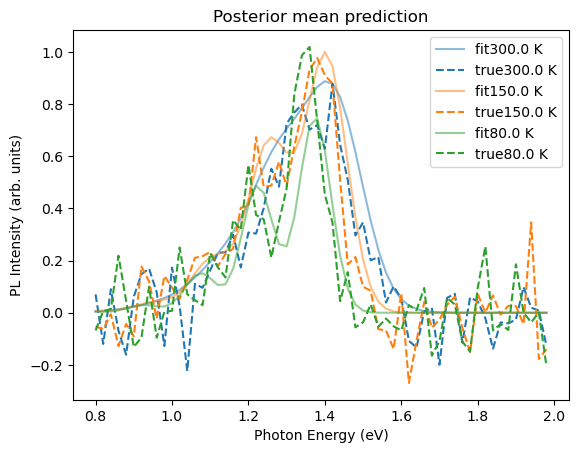

In [91]:
from pl_temp_fit import test_PYMC_pl
import importlib
importlib.reload(test_PYMC_pl)
idata, model = test_PYMC_pl.main(num_samples=10,num_tune=5,sigma=0.1)

In [6]:
theta_mean = idata.posterior.mean(dim=["chain", "draw"])
theta_mean.data_vars

Data variables:
    E        float64 1.497
    LI       float64 0.1121

In [86]:
theta_mean = idata.posterior.mean(dim=["chain", "draw"])

theta_mean_list = []
for x in theta_mean.data_vars:
    print(x)
    print(theta_mean[x].values)
    theta_mean_list.append(theta_mean[x].values)

E
1.5009238146732826
LI
0.10846784725703214


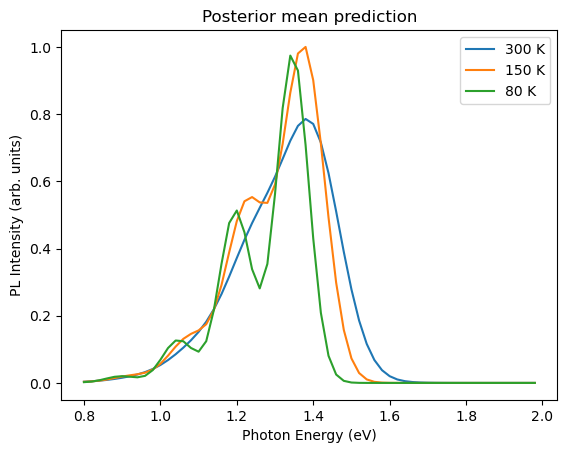

In [5]:
import numpy as np
import matplotlib.pyplot as plt

theta_mean = idata.posterior.mean(dim=["chain", "draw"])
temperature_list = [300,150,80]
theta_mean_list = []
for x in theta_mean.data_vars:
    theta_mean_list.append(theta_mean[x].values)    #theta_mean = theta_mean.to_dict()["values"]
data_plot = test_PYMC_pl.pl_trial(theta_mean_list, temperature_list)
hw = np.arange(0.8, 2, 0.02)
data_plot = data_plot.reshape(len(hw),-1) 
#data_true_plot = truemodel_pl.reshape(-1,len(hw))
fig, ax = plt.subplots()
for i in range(len(temperature_list)):
    ax.plot(hw, data_plot[:,i], label=str(temperature_list[i])+" K", linestyle="-", color="C"+str(i))
   # ax.plot(hw, data_true_plot[i], label=str(temperature_list[i])+" K", linestyle="--", color="C"+str(i))
ax.set_xlabel("Photon Energy (eV)")
ax.set_ylabel("PL Intensity (arb. units)")
ax.set_title("Posterior mean prediction")
ax.legend()
#fig.savefig(save_folder + "/posterior_mean.png")

In [ ]:
data_plot[1]

(3, 60)

In [21]:
from scipy.io import loadmat
annots = loadmat('pristineIECO-4F_11_Measured_05_09_2022_Solvent_CB_Substrate_Quartz.mat')

In [32]:
annots.keys()


dict_keys(['__header__', '__version__', '__globals__', 'None', '__function_workspace__'])

In [42]:
num_samples = [1000, 3000]
num_tune = [200, 500]
sigma = [0.1, 0.2, 0.5]
temperature_list = [[300.0, 150.0, 80.0], [300.0]]
number_free_parameters = [2, 5]
parameter_list = test_PYMC_pl.generate_parameter_list(
    num_samples, num_tune, sigma, temperature_list, number_free_parameters
)
import pandas as pd
df = pd.DataFrame(parameter_list)
df

,num_samples,num_tune,sigma,temperature_list,number_free_parameters
0,1000,200,0.1,"[300.0, 150.0, 80.0]",2
1,1000,200,0.1,"[300.0, 150.0, 80.0]",5
2,1000,200,0.1,[300.0],2
3,1000,200,0.1,[300.0],5
4,1000,200,0.2,"[300.0, 150.0, 80.0]",2
5,1000,200,0.2,"[300.0, 150.0, 80.0]",5
6,1000,200,0.2,[300.0],2
7,1000,200,0.2,[300.0],5
8,1000,200,0.5,"[300.0, 150.0, 80.0]",2
9,1000,200,0.5,"[300.0, 150.0, 80.0]",5
